In [1]:
import math
import cv2
import os
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Model, Sequential
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping
from keras.layers import Softmax, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, ReLU, Dense, Normalization, Dropout, Lambda, BatchNormalization, RandomFlip, RandomRotation
import random
from time import time
random.seed(1234)

In [2]:
# Establecemos una semilla
random.seed(1234)

# Creamos una función que lea todas las imágenes de un directorio
# concreto.
def load_images(directorio, color=0):
    x_imagenes = []
    y_imagenes = []
    for filename in os.listdir("{}/images".format(directorio)):
        filename_mask = filename[:-4]
        filename_mask = "{}_mask.png".format(filename_mask)

        nombre_x = "{}/images/{}".format(directorio, filename)
        nombre_mascara = "{}/mask/{}".format(directorio, filename_mask)
        img = cv2.imread(nombre_x,color)
        mascara = cv2.imread(nombre_mascara,0)
        if img is not None:
            x_imagenes.append(img)
            y_imagenes.append(mascara)
    return x_imagenes, y_imagenes

In [3]:

# Leemos las imágenes de entrenamiento
X_train, y_train = load_images("data/segmentation/train",1)
# Leemos las imágenes de test
X_test, y_test = load_images("data/segmentation/test",1)


In [4]:
def reescalar(conjunto_imagenes, nuevo_tam):
    imagenes_reescaladas = []
    
    for img in conjunto_imagenes:
        imagenes_reescaladas.append(cv2.resize(img, nuevo_tam))
    
    return np.array(imagenes_reescaladas)

In [5]:
NUEVO_TAM = (214, 214)

# reescalamos las imagenes al nuevo tamaño
X_train_val_reescalado = reescalar(X_train, NUEVO_TAM)
y_train_val_inicial = reescalar(y_train, NUEVO_TAM)
X_test_reescalado = reescalar(X_test, NUEVO_TAM)
y_test_inicial = reescalar(y_test, NUEVO_TAM)

X_train_val = []
X_test = []

# pasamos el rango de 0-255 con uint8 a 0-1 con float
for imagen in X_train_val_reescalado:
    X_train_val.append(imagen / 255)
    
for imagen in X_test_reescalado:
    X_test.append(imagen / 255)

X_train_val = np.array(X_train_val)
X_test = np.array(X_test)


print(X_train_val[0].dtype)

float64


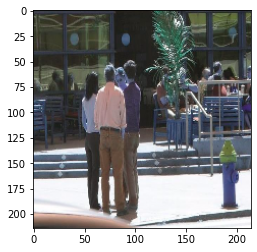

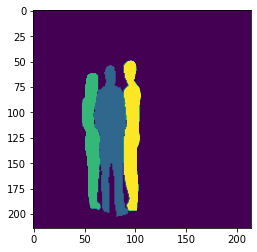

In [6]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()


# vemos que las imagenes de test tienen valores 0 para el fondo, 1 para la primera persona, 2 para la segunda, etc
plt.figure()
plt.imshow(y_train_val_inicial[0])
plt.show()

In [7]:
y_train_val = []
y_test = []

# convertimos las máscaras a imágenes de 0 o 1, 0 fondo 1 persona
for imagen in y_train_val_inicial:
    resultado = np.where(imagen == 0, 0, 1).astype(np.float64)
    resultado_negado = np.where(imagen == 0, 1, 0).astype(np.float64)
    y_train_val.append(cv2.merge((resultado, resultado_negado)))
                       

for imagen in y_test_inicial:
    resultado = np.where(imagen == 0, 0, 1).astype(np.float64)
    resultado_negado = np.where(imagen == 0, 1, 0).astype(np.float64)

    y_test.append(cv2.merge((resultado, resultado_negado)))
    
y_train_val = np.array(y_train_val)
y_test = np.array(y_test)

print(y_test.shape)

(74, 214, 214, 2)


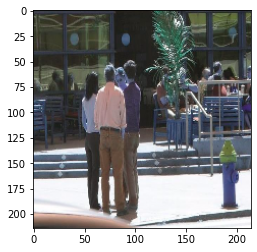

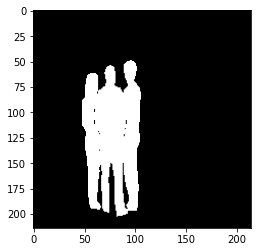

In [8]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()

# ya si aparecen como imágenes en blanco/negro
plt.figure()
plt.imshow(y_train_val[0, :, :, 0], "gray")
plt.show()

In [9]:
# separamos train en train/validacion y convertimos todos a dataset de tensorflow
ntrain = round(0.8*len(y_train_val))
nval = len(X_train_val)-ntrain

idx = np.random.permutation(np.arange(len(y_train_val)))
X_train = X_train_val[idx[0:ntrain],:]
y_train = y_train_val[idx[0:ntrain]]
X_val = X_train_val[idx[ntrain+1:len(y_train_val)],:]
y_val = y_train_val[idx[ntrain+1:len(y_train_val)]]


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



2022-06-08 18:12:27.460948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 18:12:27.461728: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 214, 214, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 214, 214, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      36928     
                                                                 
 re_lu_1 (ReLU)              (None, 107, 107, 64)      0

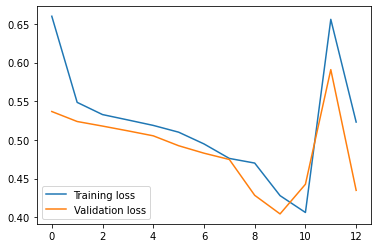

In [10]:
## Función que muestra la evolución de las accuracy de train y validación
## durante el entrenamiento.
def mostrar_evolucion(hist):

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()


modelo_base = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base.summary()

modelo_base.compile(
    optimizer = "adam", 
    loss = BinaryCrossentropy(from_logits = False)
)

# Entrenamos el modelo usando callbacks para parar de entrenar
# si la validación se aleja demasiado del entrenamiento
callback = EarlyStopping(patience=3,restore_best_weights=True)
start = time()
history = modelo_base.fit(train_dataset,
                epochs = 100,
                validation_data = validation_dataset,
                callbacks = callback)
first_training_time = time()-start
mostrar_evolucion(history)

In [11]:
predicciones = modelo_base.predict(test_dataset)

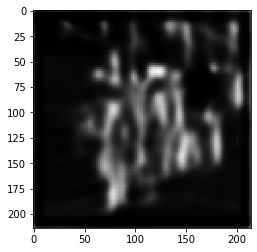

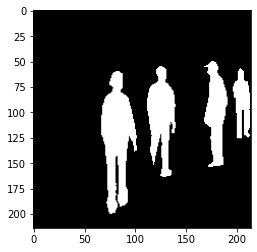

In [12]:
plt.figure()
plt.imshow(predicciones[1, :, :, 0], "gray")
plt.show()

plt.figure()
plt.imshow(y_test[1, :, :, 0], "gray")
plt.show()

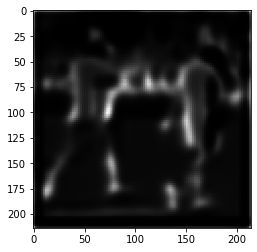

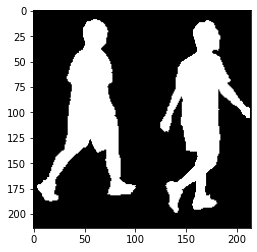

In [13]:

plt.figure()
plt.imshow(predicciones[2, :, :, 0], "gray")
plt.show()

plt.figure()
plt.imshow(y_test[2, :, :, 0], "gray")
plt.show()


In [14]:

# PATH_PREDICCIONES = "predicciones_test_segmentacion"

# if not os.path.isdir(PATH_PREDICCIONES):
#     os.mkdir(PATH_PREDICCIONES)

# i = 0
# for prediccion in predicciones:
#     cv2.imwrite("{}/img_test_{}.png".format(PATH_PREDICCIONES, i), prediccion)
#     i += 1


In [15]:
# queremos maximizar meanIoU
meanIoU_prueba = tf.keras.metrics.MeanIoU(num_classes=2)
meanIoU_prueba.update_state([0, 0, 1, 1], [0, 0, 1, 1])
print(meanIoU_prueba.result().numpy())

1.0


In [31]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)


meanIoU.update_state(predicciones[:, :, :, 0], y_test[:, :, :, 0])

print(meanIoU.result().numpy())

0.43090215


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 214, 214, 3)      7         
 ion)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 214, 214, 64)      1792      
                                                                 
 re_lu_3 (ReLU)              (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 107, 107, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 64)      36928     
                                                                 
 re_lu_4 (ReLU)              (None, 107, 107, 64)     

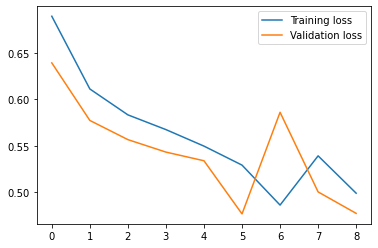

In [17]:

modelo_base_deep = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base_deep.summary()

modelo_base_deep.compile(
    optimizer = "adam", 
    loss = BinaryCrossentropy(from_logits = False)
)

# Entrenamos el modelo usando callbacks para parar de entrenar
# si la validación se aleja demasiado del entrenamiento
callback = EarlyStopping(patience=3,restore_best_weights=True)
start = time()
history = modelo_base_deep.fit(train_dataset,
                epochs = 100,
                validation_data = validation_dataset,
                callbacks = callback)
first_training_time = time()-start
mostrar_evolucion(history)

In [32]:
predicciones_deep = modelo_base_deep.predict(test_dataset)

meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)

meanIoU.update_state(predicciones_deep[:, :, :, 0], y_test[:, :, :, 0])

print(meanIoU.result().numpy())

0.43090215


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 214, 214, 3)      7         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 214, 214, 64)      1792      
                                                                 
 re_lu_8 (ReLU)              (None, 214, 214, 64)      0         
                                                                 
 average_pooling2d (AverageP  (None, 107, 107, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_13 (Conv2D)          (None, 107, 107, 64)      36928     
                                                                 
 re_lu_9 (ReLU)              (None, 107, 107, 64)     

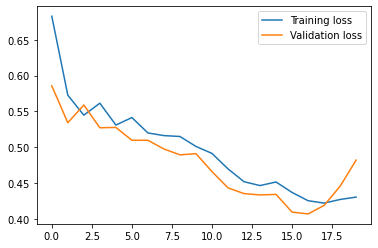

In [19]:

modelo_base_avg = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base_avg.summary()

modelo_base_avg.compile(
    optimizer = "adam", 
    loss = BinaryCrossentropy(from_logits = False)
)

# Entrenamos el modelo usando callbacks para parar de entrenar
# si la validación se aleja demasiado del entrenamiento
callback = EarlyStopping(patience=3,restore_best_weights=True)
start = time()
history = modelo_base_avg.fit(train_dataset,
                epochs = 100,
                validation_data = validation_dataset,
                callbacks = callback)
first_training_time = time()-start
mostrar_evolucion(history)

In [33]:
predicciones_avg = modelo_base_avg.predict(test_dataset)

meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)

meanIoU.update_state(predicciones_avg[:, :, :, 0], y_test[:, :, :, 0])

print(meanIoU.result().numpy())

0.43090215
